In [57]:
import os
import glob
import time
import numpy as np
from PIL import Image
from pathlib import Path
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import matplotlib
from skimage.color import rgb2lab, lab2rgb

import torch
from torch import nn, optim
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [58]:
from google.colab import drive

drive.mount('/content/Mydrive/')

Drive already mounted at /content/Mydrive/; to attempt to forcibly remount, call drive.mount("/content/Mydrive/", force_remount=True).


In [59]:
!pip install fastai==2.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [86]:
from google.colab import drive

drive.mount('/content/Mydrive/')

Drive already mounted at /content/Mydrive/; to attempt to forcibly remount, call drive.mount("/content/Mydrive/", force_remount=True).


In [87]:
from fastai.data.external import untar_data, URLs
coco_path = untar_data(URLs.COCO_SAMPLE) # COCO 데이터셋 다운로드 이후 압축해제
paths = glob.glob(str(coco_path) + "/train_sample/*.jpg") # paths 변수에 모든 이미지의 경로를 리스트로 저장. , 실무에서 많이 쓰이는 표현!!!


In [88]:
paths_hospital = glob.glob("/content/Mydrive/MyDrive/졸작/mediapipe_img/*.jpg")
print(paths_hospital)

['/content/Mydrive/MyDrive/졸작/mediapipe_img/221114_170105.jpg', '/content/Mydrive/MyDrive/졸작/mediapipe_img/221114_170148.jpg']


In [89]:
import os

latest_picture = paths_hospital[-1]
print(latest_picture)

dcgan_picture = os.path.basename(latest_picture)

/content/Mydrive/MyDrive/졸작/mediapipe_img/221114_170148.jpg


In [90]:
np.random.seed(1) # 언제나 데이터를 똑같이 나누기 위해 시드 설정
chosen_paths = np.random.choice(paths, 100, replace=False) # 5000장의 이미지의 경로를 랜덤으로 paths_subset에 저장
index = np.random.permutation(100) # 10000 안에서 랜덤으로 인덱스 생성

train_paths = chosen_paths[index[:80]] # 8000번째까지를 training set 경로로 지정
val_paths = chosen_paths[index[80:]] # 나머지 2000개를 validation set 경로로 지정
print(len(train_paths), len(val_paths))

80 20


In [91]:
print(paths_hospital)

['/content/Mydrive/MyDrive/졸작/mediapipe_img/221114_170105.jpg', '/content/Mydrive/MyDrive/졸작/mediapipe_img/221114_170148.jpg']


In [92]:
train_paths = np.append(train_paths,paths_hospital,axis=0)
print(train_paths)

['/root/.fastai/data/coco_sample/train_sample/000000036303.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000437356.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000436108.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000105933.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000338651.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000186018.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000479729.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000347790.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000443248.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000186856.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000425123.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000055689.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000480161.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000369774.jpg'
 '/root/.fastai/data/coco_sample/train_sample/000000144937.jpg'
 '/root/.fastai/data/coco_sample/train_s

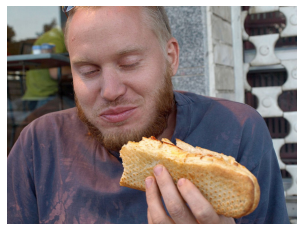

In [93]:
sample = matplotlib.image.imread(train_paths[0]) # 0번째 이미지를 출력한다
plt.imshow(sample)
plt.axis('off')
plt.show()

In [94]:
from torch.utils.data import Dataset

### 이미지 전처리 클래스 생성

class ColorizationDataset(Dataset):
  def __init__(self, paths, mode='train'): # class가 생성될 때 실행되는 생성자
    self.mode = mode
    self.paths = paths

    if mode == 'train': # train일 경우
      self.transforms = transforms.Compose([ # pytorch.transforms.Compose를 사용하여 이미지 사이즈 조정과 데이터 증강을 체이닝 시키기.
                                            transforms.Resize((256, 256), Image.BICUBIC), # Bicubic 보간법을 활용하여 이미지 사이즈 조정
                                            transforms.RandomHorizontalFlip(), # 수평 반전으로 데이터 증강
      ])
    elif mode == 'val': # validation일 경우
      self.transforms = transforms.Resize((256, 256), Image.BICUBIC)
    else:
      raise Exception("train or val only!") # 예외처리
    
  def __getitem__(self, index): # 클래스의 인덱스에 접근할때 호출되는 메서드
    img = Image.open(self.paths[index]).convert("RGB") #꿀팁! -> 이미지 불러오기. 혹시 RGB가 아닌 이미지가 있을 수도 있으니 convert("RGB")
    img = np.array(self.transforms(img)) # 이미지 transform 진행 후 numpy array로 변환
    img = rgb2lab(img).astype("float32") # RGB 채널을 Lab 채널로 변환
    img = transforms.ToTensor()(img) # 텐서로 변환
    L = img[[0], ...] / 50. - 1. # -1부터 1 사이로 정규화
    ab = img[[1, 2], ...] / 110. # -1부터 1 사이로 정규화
    
    return {'L': L, 'ab': ab} # L채널과 ab채널을 따로 정규화를 시켜준다
  
  def __len__(self):
    return len(self.paths)


In [95]:
dataset_train = ColorizationDataset(train_paths, mode='train')
dataset_val = ColorizationDataset(val_paths, mode='val')

dataloader_train = DataLoader(dataset_train, batch_size=1, num_workers=2, pin_memory=True) #pin_memory: 메모리를 할당하는 특정 구역을 고정으로 시켜서 데이터로드를 빠르게 도와줌
dataloader_val = DataLoader(dataset_val, batch_size=1, num_workers=2, pin_memory=True)


# 이미지를 불러올 때 항상 convert() 함수를 써주자!!! 
# 왜냐하면 RGB가 아닌 이미지를 불러올 수도 있기 때문에 해당 메서드 안써주면 어디서 오류났는지 몰라서 삽질한다

In [96]:
data = next(iter(dataloader_train)) # 데이터 로더의 첫 데이터를 하나 가져온다는뜻
Ls, abs = data['L'], data['ab'] # 위쪽 def __getitem__()메서드에서 L과 ab를 각각 리턴했기 때문에 받아올때도 L과 ab를 따로 받아온다
print(Ls.shape, abs.shape)

#결과 : torch.Size([16, 1, 256, 256]) torch.Size([16, 2, 256, 256])
# ------> [배치 사이즈, 채널 갯수, 사이즈, 사이즈 ]
# -------> 즉, Ls는 16배치사이즈, 'L'이라는 채널 1개, 사이즈 256x256
# -------> 즉, abs는 16배치사이즈, 'ab'이라는 채널 2개, 사이즈 256x256

torch.Size([1, 1, 256, 256]) torch.Size([1, 2, 256, 256])


In [97]:
# generator를 생성하자!!!!

# 클래스를 선언하자!!!

class pix2pix_Generator(nn.Module):
  
  #생성자 선언! __init__
  def __init__(self):
    super(pix2pix_Generator, self).__init__()

    self.input_layer = nn.Sequential(
        nn.Conv2d(1, 64, kernel_size=4, stride=2, padding=1, bias=False),
    )  # 1채널을 받아(input) 64채널로 출력(output), bias는 false

    self.encoder_1 = nn.Sequential(
        nn.LeakyReLU(0.2,True),
        nn.Conv2d(64,128, kernel_size=4, stride=2, padding=1, bias=True), 
        nn.BatchNorm2d(128) # 만든 128채널을 넣는다        
    ) # input_layer메서드에서 완료된 채널인 64채널을 받아(input) 128채널로 출력(output), bias는 true


    self.encoder_2 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(256)
    )  # encoder_1메서드에서 완료된 채널인 128을 받아 256채널로 출력

    self.encoder_3 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(256,512,kernel_size=4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(512)
    )  # encoder_2메서드에서 완료된 채널인 256을 받아 512채널로 출력

    self.encoder_4 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512,512,kernel_size=4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(512)
    )  # encoder_3메서드에서 완료된 채널인 512을 받아 512채널로 출력


     
    self.encoder_5 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512,512,kernel_size=4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(512)
    )  # encoder_4메서드에서 완료된 채널인 512을 받아 512채널로 출력


    self.encoder_6 = nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512,512,kernel_size=4, stride=2, padding=1, bias=True),
        nn.BatchNorm2d(512)
    )  # encoder_5메서드에서 완료된 채널인 512을 받아 512채널로 출력



   # U-NET: incoder -> middle -> decoder. 따라서 decoder 이전에 middle을 하나 만들어주자
    self.middle=nn.Sequential(
        nn.LeakyReLU(0.2, True),
        nn.Conv2d(512,512,kernel_size=4, stride=2, padding=1, bias=False),
        nn.ReLU(True),
        nn.ConvTranspose2d(512, 512, kernel_size=4, stride=2, padding=1, bias=False), # 바로 위에 타이핑한 컨볼루션(Conv2d)에서 나온 출력값 512를 받아서 트랜스포즈의 입력값으로 쓰인다
        # ConvTranspose2d: 사이즈를 크게 해주는 컨볼루션이라고 생각하면된다
        nn.BatchNorm2d(512)
    )

    # decoder를 하자
    self.decoder_6 = nn.Sequential(
        
        nn.ReLU(True),
        nn.ConvTranspose2d(1024,512, kernel_size=4, stride=2, padding=1, bias=False),
        #middle구간에서 출력한 512보다 2배 큰 1024를 입력값으로 넣어준다.
        #encoder의 마지막 출력값 512이고, middle의 출력값도 512인데, decoding을 위해 torch.cat()메서드를 사용할 때 두 값들이 합쳐져서 decoding되므로 512+512=1024
        
        nn.BatchNorm2d(512),
        nn.Dropout(0.5) # decoder를 0.5의 확률로 할지 말지 결정해주는 역할. 그러나 안써도 된다. 오히려 안쓰는게 좋다. 옛날 논문이라 기재가 되어서 그냥 타이핑한것임.
    )

    self.decoder_5 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024,512,kernel_size=4, stride=2, padding=1, bias=False),
        # torch.cat()을 사용하므로, decoder_6을 통해 출력된 값 512의 2배인 1024를 decoder_5의 입력값으로 쓴다. 이때 출력되는 값은 마찬가지로 512
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    self.decoder_4 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024,512,kernel_size=4, stride=2, padding=1, bias=False),
        # torch.cat()을 사용하므로, decoder_5을 통해 출력된 값 512의 2배인 1024를 decoder_4의 입력값으로 쓴다. 이때 출력되는 값은 마찬가지로 512
        nn.BatchNorm2d(512),
        nn.Dropout(0.5)
    )

    #output값 변형되는 지점
    self.decoder_3 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(1024,256,kernel_size=4, stride=2, padding=1, bias=False),
        # torch.cat()을 사용하므로, decoder_4을 통해 출력된 값 512의 2배인 1024를 decoder_3의 입력값으로 쓴다. 단, 이때부터는 출력되는 값을 256으로 수정한다
        nn.BatchNorm2d(256),
        nn.Dropout(0.5)
    )

    self.decoder_2 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(512,128,kernel_size=4, stride=2, padding=1, bias=False),
        # torch.cat()을 사용하므로, decoder_3을 통해 출력된 값 256의 2배인 512를 decoder_2의 입력값으로 쓴다. 이때 출력되는 값은 128로 지정한다
        nn.BatchNorm2d(128),
        nn.Dropout(0.5)
    )

    self.decoder_1 = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(256,64,kernel_size=4, stride=2, padding=1, bias=False),
        # torch.cat()을 사용하므로, decoder_2을 통해 출력된 값 128의 2배인 1024를 decoder_5의 입력값으로 쓴다. 이때 출력되는 값은 64로 한다
        nn.BatchNorm2d(64),
        nn.Dropout(0.5)
    )


  #output 레이어
    self.output_layer = nn.Sequential(
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 2, kernel_size=4, stride=2, padding=1),
        #torch.cat() 사용 안하므로 2배값 받아올 필요 없다. 그냥 마지막 decoder 출력값 64 그대로 받아온다
        #그리고 어떤 채널을 output으로 설정할 지를 적어준다. 여기서는 'ab'채널을 설정할 것이므로 2로 설정한다.
        nn.Tanh()
    )

  
  #forward 신전파 방향을 설정해준다
  def forward(self, x): #바로 위에 정의한 self 초기화 함수들(self.encoder, self.decoder, self.output 등등)을 받고, input값으로 x를 받는다 
    
    input_layer = self.input_layer(x) # 위쪽에서 처음 정의한 self.input_layer함수를 받아온다

    encoder_1 = self.encoder_1(input_layer) #바로 위에서 받은 input_layer를 self.encoder_1의 입력값으로 다시 받아 encoder_1에 저장한다
    encoder_2 = self.encoder_2(encoder_1) # 바로 위에서 받은 encoder_1의 값을 self.encoder_2의 입력값으로 받아와 encoder_2에 저장한다
    encoder_3 = self.encoder_3(encoder_2)
    encoder_4 = self.encoder_4(encoder_3)
    encoder_5 = self.encoder_5(encoder_4)
    encoder_6 = self.encoder_6(encoder_5)

    middle = self.middle(encoder_6) # 마지막 encoder값을 middle 입력값으로 받아와 middle에 저장한다

    cat_6 = torch.cat((middle, encoder_6), dim=1) # middle값과, encoder_6값을 서로 합치기 위해 torch.cat()함수 사용.
    decoder_6 = self.decoder_6(cat_6) # 위쪽에 self.decoder_6이 왜 입력값으로 1024를 받는지 설명해주는 문장.(middle+encoder6 = 1024이므로)
    cat_5 = torch.cat((decoder_6, encoder_5), dim=1) #decoder_6는 순정파 방향이라 그냥 그대로 들어가고, encoder_5는 decoder_5와 같은선상에 있으므로 넣는다 
    decoder_5 = self.decoder_5(cat_5)
    cat_4 = torch.cat((decoder_5, encoder_4), dim=1)
    decoder_4 = self.decoder_4(cat_4)
    cat_3 = torch.cat((decoder_4, encoder_3), dim=1)
    decoder_3 = self.decoder_3(cat_3)
    cat_2 = torch.cat((decoder_3, encoder_2), dim=1)
    decoder_2 = self.decoder_2(cat_2)    
    cat_1 = torch.cat((decoder_2, encoder_1), dim=1)
    decoder_1 = self.decoder_1(cat_1)

    x = self.output_layer(decoder_1)

    return x




  

In [98]:
# class를 선언!!!(nn.Module)

class pix2pix_Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
        nn.LeakyReLU(0.2,True), 
        # 3채널을 받아 진짜 이미지(real data)로 오는지, 가짜 이미지(fake data)로 오는지 확인함
        # 'L'채널과 'ab'채널을 각각 nn.Conv2d(2, ) , nn.Conv2d(1, )으로 따로 컨볼루션해서 값을 도출해도 괜찮다. 
        # 다만 nn.Conv2d(3, )과 차이가 조금 있으니 비교해보는것도 좋음         


        nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(128),
        nn.LeakyReLU(0.2,True),


        nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(256),
        nn.LeakyReLU(0.2,True),        


        nn.Conv2d(256,512,kernel_size=4, stride=1, padding=1, bias=False),
        nn.BatchNorm2d(512),
        nn.LeakyReLU(0.2,True),

        nn.Conv2d(512,1, kernel_size=4, stride=1, padding=1, bias=False)
        # 참인지,거짓인지만 확인하면 되므로 1을 부여한다

    )

  def forward(self,x):
    return self.model(x)

In [99]:
pix2pix_Discriminator()

pix2pix_Discriminator(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1), bias=False)
  )
)

In [100]:
discriminator = pix2pix_Discriminator()
dummy_input = torch.randn(16,3,256,256)
out = discriminator(dummy_input)
out.shape

torch.Size([16, 1, 30, 30])

In [101]:
# pix2pix_Discriminator()

# 첫 번째 함수
def init_weight(m):
  if type(m) == nn.Conv2d:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02) # m모델의 가중치(weight)의 값(data)를 불러옴
    print("Convolution layer has been initialized!!!")

  elif type(m) == nn.ConvTranspose2d:
    nn.init.normal_(m.weight.data, mean=0.0, std=0.02) #mean=0.0, std=0.02는 논문에서 기재된 값. '이게 괜찮더라'하는 엔지니어링 값이라고 생각하면됨.
    print("Tranpose Convolution layer has been initialized!!!")

  elif type(m) == nn.BatchNorm2d:
    nn.init.normal_(m.weight.data, mean=1.0, std=0.02) # mean=0.0으로 맞춰도 상관은 없음
    nn.init.constant_(m.bias.data, 0.)
    print("BatchNorm2d layer has been initialized!!!")

  




# 두번째 함수
def initialize_model(model):
  model.apply(init_weight) # init_weight를 불러오는 메서드
  return model

In [102]:
class GANLoss(nn.Module):
  
  def __init__(self):
    super().__init__()
    self.register_buffer('real_label', torch.tensor(1.0))
    self.register_buffer('fake_label', torch.tensor(0.0))
    self.loss = nn.BCEWithLogitsLoss() # 실제 loss함수와 관련된 문법은 GANLoss클래스에서 이 문장 하나밖에 없음

  def get_labels(self, preds,target_is_real): #preds:예측값
    if target_is_real:
      labels = self.real_label # 타겟이 진짜라면 그대로 쓰겠다

    else:
      labels = self.fake_label
    return labels.expand_as(preds) # real_label, fake_label 값이 저장된 labels의 크기를 expands_as를 통해  preds와 같게 하여 번거로움을 줄이겠다는 의도
  
  def __call__(self,preds,target_is_real):
    labels = self.get_labels(preds,target_is_real)
    loss = self.loss(preds,labels)
    return loss

In [103]:
# lab를 rgb로 만드는 함수를 만든다
def lab_to_rgb(L,ab):
  # 정규화된 Lab 채널을 다시 원상태로 복귀합시다!
  L = (L+1)*50.
  ab = ab * 110.
  # def __getitem__(self,index)메서드의 L, ab방식을 역순으로 적용한다
  #  L = img[[0], ...] / 50. - 1. # -1부터 1 사이로 정규화
  #  ab = img[[1, 2], ...] / 110. # -1부터 1 사이로 정규화
  
  
  # Lab 컬러 채널을 만들어 봅시다!!!
  Lab = torch.cat([L,ab], dim=1).permute(0,2,3,1).cpu().numpy()
  #  permute()함수 기능: [배치 사이즈, 채널, 256, 256] -> [배치 사이즈, 256, 256, 채널]로 변경해줌


  # rgb 이미지들을 저장할 리스트를 선언.
  rgb_imgs = []
  # Lab에 있는 이미지들을 한장씩 꺼내서 rgb로 바꿔봅시다!
  for img in Lab:
    img_rgb = lab2rgb(img)
    #rgb로 바뀐 이미지들을 리스트에 추가!
    rgb_imgs.append(img_rgb)
  return np.stack(rgb_imgs, axis=0)



In [104]:
import warnings

# generator 모델을 생성한 후 초기화한다
model_generator = initialize_model(pix2pix_Generator()) # generator 초기화
# generator 모델을 gpu로 보내준다!
model_generator.to(device) # GPU에 던져줌(처음 코드에 device = torch.device("cuda" if torch.cuda.is_available() else "cpu"))

# discriminator 모델을 생성한 후 초기화한다
model_discriminator = initialize_model(pix2pix_Discriminator())
# discriminator 모델을 gpu로 보내준다!!
model_discriminator.to(device)


# <중요!>: 항상 gpu를 보내주는 처리는 앞에서 미리 해두자. 특히 파이토치의 경우 gpu, cpu 위치가 섞이면 오류가 날 수 있다. 그러니 미리 gpu에 다 옴겨주는 처리를 해두자.

# 로스 함수 선언하기!
criterion = GANLoss().to(device) # 주로 로스함수 선언하는 변수를 criterion을 사용함
L1 = nn.L1Loss()

# 옵티마이저 만들어야함.(항상 마지막에 옵티마이저를 한다. 왜냐하면 '무엇을' 옵티마이징 할지 먼저 대상들을 정의해야 옵티마이저 가능하므로)
optimizer_generator = optim.Adam(model_generator.parameters(), lr=2e-4, betas=(0.5, 0.999)) # model generator의 'parameter'를 초기화해줌(), 왠만하면 betas는 업계에서도 절대 안건들임, lr을 주로 조정하는편
optimizer_discriminator = optim.Adam(model_discriminator.parameters(), lr=2e-4, betas=(0.5, 0.999))

# 에포크를 선언( = 얼마나 데이터를 학습 시킬 것인가?)
epochs = 10 #(10000만큼 훈련시킨다)

# 실제 훈련을 시작!!!
# 에포크가 돈다!!! -> 전체 트레이닝 셋이 다 훈련이 되었다는 뜻.(데이터 하나가 한번 훈련되는것: 이터레이션, 데이터 전체가 훈련되는것: 에포크)
for e in range(epochs):
  # tqdm이라는 라이브러리를 사용해서 for loop이 얼마나 돌았는지를 확인하자!
  for index, data in enumerate(tqdm(dataloader_train)):
    L = data['L'].to(device) # L채널 데이터를 dataloader_train으로부터 뽑아 'gpu'로 보내준다(.to(device))
    ab = data['ab'].to(device) # ab채널 데이터를 dataloader_train으로부터 뽑아 'gpu'로 보내준다(.to(device))

    # generator에 L채널을 넣고, fake color를 얻어내자!
    fake_color = model_generator(L)
    
    # discriminator를 훈련시키자!!!
    model_discriminator.train() # discriminator는 훈련 시작, 여기선 아직 generator는 훈련 시작 안함
    #discriminator를 훈련시키기 위해서 discriminator에 대한 모든 기울기를 저장하고, 백프롭시키자!
    for parameter in model_discriminator.parameters():
      parameter.requires_grad = True

    # zero_grad -> pytorch에서는 iteration이 끝나면 항상 gradient를 0으로 만들어 주어야 함. 안그러면 서로 충돌남. 영향을 줌.
    optimizer_discriminator.zero_grad() 

    # L 채널이랑 fake_color를 합쳐서 가짜 이미지를 만들어 봅시다!!!
    fake_image = torch.cat([L, fake_color],dim=1)

    # 가짜 이미지를 discriminator에 넣어줍시다!!!
    # 이전 iteration이 다음 iteration에 영향을 주지 못하도록 각각 독립되게 만들기 위해 detach한다고 생각하면됨
    # .detach를 쓰면 역전파가 일어나지 않고 순전파가 일어난다.(그냥 .copy를 쓰면 그대로 복사되어 역전파가 일어남)
    fake_preds = model_discriminator(fake_image.detach()) 
    
    # discriminator의 로스를 계산해봅시다!!
    loss_discriminator_fake = criterion(fake_preds, False) # 가짜 데이터이므로 false 값으로 설정한다

    # 진짜 이미지를 만들어 봅시다!
    real_image = torch.cat([L,ab], dim=1)
    # 진짜 이미지를 discriminator에 넣어줍시다!!!
    real_preds = model_discriminator(real_image)
    # discriminator의 로스를 계산해봅시다!!! 
    loss_discriminator_real = criterion(real_preds, True) # 진짜 데이터이므로 true 값으로 설정한다

    loss_discriminator_total = (loss_discriminator_fake + loss_discriminator_real) * 0.5 
    #(fake + real로 인해 사이즈가 커진것을 0.5를 곱해 절반으로 줄여줌. 속도개선이라 반드시 할 필요는 없음)

    # 역전파합시다!!!(.backward())
    loss_discriminator_total.backward()
    # 최적화합시다!!!
    optimizer_discriminator.step()



    #<generator>파트

    # generator를 학습시킵시다!!
    model_generator.train()

    # discriminator를 잠시 학습 중단시킵시다! freeze!( ** 왜 discriminator 실행 시에는 freeze 없나? -> 애초에 학습되는 행위가 일어나지 않았으므로 멈출 것도 없다!)
    for parameter in model_generator.parameters():
      parameter.requires_grad = False
    # generator를 zero_grad 해줍시다!
    optimizer_generator.zero_grad() 
   
    # 가짜 이미지를 생성해봅시다!
    fake_image = torch.cat([L,fake_color], dim=1)
    # generator가 생성한 이미지를 discriminator에 넣어보자!
    fake_preds = model_discriminator(fake_image)
    # 결과값을 loss 계산합시다!
    loss_generator_GAN = criterion(fake_preds, True) # 가짜 데이터지만 훈련을 시켜주기 위해 'True'값으로 설정한다.("(사실은 가짜지만)이거 진짜야!"하고 gan을 훈련시켜주는것)
    # generator가 생성한 이미지에 L1 Loss를 걸어줍시다!! 람다 = 100
    loss_generator_L1 = L1(fake_color, ab) * 100. # 100=람다값(고정된 값은 아니고 연구해보며 '이 값이 결과치가 좋더라'하는 값을 넣어둔것임)    
    # 사칙연산으로 loss를 더해준다.
    loss_generator_total = loss_generator_GAN + loss_generator_L1


    # 역전파
    loss_generator_total.backward()
    # 옵티마이즈!
    optimizer_generator.step()



    # 100번째 인덱스마다 이미지를 그려봅시다!!
    if (index==len(train_paths)-1 or index==len(train_paths)-2):
      # 몇 번째 에포크인지 출력
      print(f"\n Epoch {e+1}/{epochs}")

      # 몇 번째 인덱스인지 출력
      print(f"Iteration {index}/{len(dataloader_train)}")

      # 자잘한 오류 메세지를 무시하기 위해 사용한다!(꿀팁!)
      with warnings.catch_warnings():
        warnings.simplefilter("ignore")

        # generator가 훈련되면 안되니까 eval mode로 전환한다!
        model_generator.eval() # 이제부터는 pass모드로 작동하겠다는 뜻
        # generator가 훈련되면 안되니까 기울기 업데이트를 막아버리자!
        with torch.no_grad():
      #   for index, data in enumerate(tqdm(dataloader_train)) 넣어보기
          L = data['L'].to(device)
          ab = data['ab'].to(device)
          # 가짜 색을 만들자!
          fake_color = model_generator(L)
        
        # generator가 이미지를 그리는데 있어서 할 일을 다 했으니, 다시 훈련모드로 돌려놓자
        model_generator.train()
        # fake color가 기울기에 영향받지 않게 복사해주자!
        fake_color = fake_color.detach()
        # real color를 선언합시다!
        real_color = ab

        # 가짜 이미지를 생성하자!
        fake_imgs = lab_to_rgb(L, fake_color) # 위에서 선언한 함수 lab_to_rgb를 사용
        # 진짜 이미지를 생성하자!
        real_imgs = lab_to_rgb(L, real_color)


        fig = plt.figure(figsize=(10,8)) # 가로x세로 10x8 사이즈로 출력
                
        ax = plt.subplot(3,3,1) # 3장을 만들되, 1번째 사진을 출력한다
        ax.imshow(L[0][0].cpu(), cmap='gray')
        ax.axis("off")

        ax = plt.subplot(3,3,2) # 3장을 만들되, 2번째 사진을 출력한다
        ax.imshow(fake_imgs[0])
        ax.axis("off")

        ax = plt.subplot(3,3,3) # 3장을 만들되, 3번째 사진을 출력한다
        ax.imshow(real_imgs[0])
        ax.axis("off")

        plt.show()

        if index==len(train_paths)-1:
          save_img = fake_imgs[0].copy()

        if index==len(train_paths)-2:
          save_img2 = fake_imgs[0].copy()

            
              



 



    

    


Output hidden; open in https://colab.research.google.com to view.

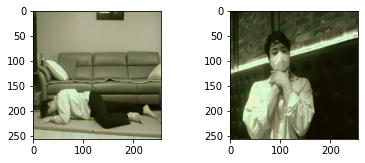

In [108]:
fig = plt.figure(figsize=(10,8)) # 가로x세로 10x8 사이즈로 출력
                
ax = plt.subplot(3,3,1) # 3장을 만들되, 1번째 사진을 출력한다

ax.imshow(save_img)

ax = plt.subplot(3,3,2) # 3장을 만들되, 1번째 사진을 출력한다

ax.imshow(save_img2)


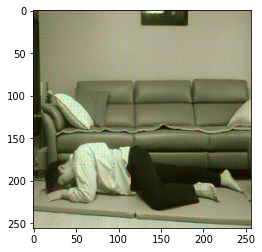

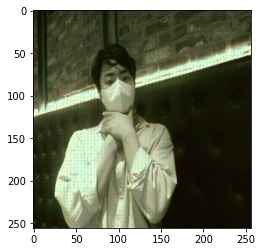

In [109]:
import numpy as np
from PIL import Image
import cv2
import time

min_or = save_img.min()
max_or = save_img.max()
img_uint = ((save_img - min_or) / (max_or - min_or)*255.).astype(np.uint8)
#numpy array -> image 변형시 float64타입이 uint8으로 변경되므로 숫자 범위를 조절해줘야함


a=Image.fromarray(img_uint,mode='RGB')



min_or2 = save_img2.min()
max_or2 = save_img2.max()
img_uint2 = ((save_img2 - min_or2) / (max_or2 - min_or2)*255.).astype(np.uint8)
#numpy array -> image 변형시 float64타입이 uint8으로 변경되므로 숫자 범위를 조절해줘야함


a2=Image.fromarray(img_uint2,mode='RGB')


plt.imshow(a)
plt.show()


plt.imshow(a2)
plt.show()

timestr = time.strftime("%Y%m%d_%H%M%S")

a.save('/content/Mydrive/MyDrive/졸작/save_img/' +dcgan_picture)
a2.save('/content/Mydrive/MyDrive/졸작/save_img/'+'_1'+dcgan_picture)
#만약 동일한 이름의 파일이 폴더 내에 있을경우 자동으로 덮어쓰기됨

In [110]:
print(paths_hospital[-1])
print(dcgan_picture)

/content/Mydrive/MyDrive/졸작/mediapipe_img/221114_170148.jpg
221114_170148.jpg
